# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import re
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 3

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
# model_dir = os.path.abspath("../mass_user/models")
# maps_dir = os.path.abspath("../mass_user/maps")
# data_dir = os.path.abspath("../mass_user/data")

In [4]:
# # **changed the path depending on the file on where the files are located**
model_dir = os.path.abspath("/Users/RiyaMathur/Coding HERE/MASSliver/models")
maps_dir = os.path.abspath("/Users/RiyaMathur//Coding HERE/MASSliver/models/maps")
data_dir = os.path.abspath("/Users/RiyaMathur//Coding HERE/MASSliver/data/interim")

In [5]:
# model_dir = os.path.abspath(".../MASSliver/models")
# maps_dir = os.path.abspath(".../MASSliver/models/maps")
# data_dir = os.path.abspath(".../MASSliver/data/interim")

In [6]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [7]:
#load core model
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07fb084415d90
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [8]:
#create trial model
trial = Model('Smaller Glycogenolysis') 
trial

Name,Smaller Glycogenolysis
Memory address,0x07fb084441fa0
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


In [9]:
#load Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [10]:
#add all reactions to a list
R3D_list=[
    'HEX1',
    'PGI', 
    'PFK',
    'FBP',
    'FBA',
    'TPI',
    'GAPD',
    'PGK',
    'PGM',
    'ENO',
    'PYK',
    'PYRt2m',
    'PCm',
    'PEPCKm',
    'LDH_L',
    'G6PPer',
    'G6Pter',
    'GLCter',
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'EX_glc__D_e',
    'GLCt1',
    'Ht',
    'L_LACt2r', #lactose transport between lactate in cytosol and extracellular 
     'PYRt2' #pyruvate transport between pyruvate in cytosol and extracellular 
]
#add reactions from R3D to trial model
for rid in R3D_list:
    reaction = R3D.reactions.get_by_id(rid)
    trial.add_reactions([reaction])
    
#add reactions from core to trial model

## make peptm
core_list=['PEPtm']
for rid in core_list:
    reaction = core_model.reactions.get_by_id(rid)
    trial.add_reactions([reaction])

In [11]:
#get metabolites for sinks/exchanges
pyrc=R3D.metabolites.get_by_id('pyr_c') #need these exchanges since they create more FBA values
pyrm=R3D.metabolites.get_by_id('pyr_m')

pepm=R3D.metabolites.get_by_id('pep_m')
oaam=R3D.metabolites.get_by_id('oaa_m')

hco3=R3D.metabolites.get_by_id('hco3_m')
co2=R3D.metabolites.get_by_id('co2_m')
gtp=R3D.metabolites.get_by_id('gtp_m')
gdp=R3D.metabolites.get_by_id('gdp_m')

atpc=R3D.metabolites.get_by_id('atp_c')
atpm=R3D.metabolites.get_by_id('atp_m')
adp=R3D.metabolites.get_by_id('adp_c')
adpm=R3D.metabolites.get_by_id('adp_m')

h2o=R3D.metabolites.get_by_id('h2o_e')
pie=R3D.metabolites.get_by_id('pi_e')
pim=R3D.metabolites.get_by_id('pi_m')
he=R3D.metabolites.get_by_id('h_e')
hm=R3D.metabolites.get_by_id('h_m')
nadh=R3D.metabolites.get_by_id('nadh_c')
nad=R3D.metabolites.get_by_id('nad_c')


pyre = R3D.metabolites.get_by_id("pyr_e")
lace = R3D.metabolites.get_by_id("lac__L_e")

In [12]:
# create sink/exchange reaction
trial.add_boundary(atpc, type="sink")
trial.add_boundary(gtp, type="sink")
trial.add_boundary(gdp, type="sink")
trial.add_boundary(atpm, type="sink")
trial.add_boundary(pyrm, type="sink")
trial.add_boundary(pyrc, type="sink")

trial.add_boundary(pepm, type="sink")
trial.add_boundary(oaam, type="sink")

trial.add_boundary(nadh, type="sink")
trial.add_boundary(nad, type="sink")
trial.add_boundary(adp, type="sink")
trial.add_boundary(adpm, type="sink")
trial.add_boundary(hm, type="sink")
trial.add_boundary(hco3, type="sink")
trial.add_boundary(co2, type="sink")
trial.add_boundary(pim, type="sink")

#why are these exchanges
trial.add_boundary(h2o, type="exchange")
trial.add_boundary(pie, type="exchange")
trial.add_boundary(he, type="exchange")
trial.add_boundary(pyre, type="exchange")
trial.add_boundary(lace, type="exchange")

Reaction identifier,EX_lac__L_e
Name,L-Lactate exchange
Memory address,0x07fb074320a60
Stoichiometry,lac__L_e <=> L-Lactate <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


## View Escher map

In [13]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [14]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [15]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"4.1-srp-rm-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1)
flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
G6PPer,0.001682
HEX1,0.000000
GLCt1,-0.001682
PGI,-0.002919
EX_glc__D_e,0.085498
FBP,0.002919
PFK,0.000000
FBA,-0.002919
GAPD,-0.002919


In [16]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]
irreversible_enzyme_pairs2 = ["HEX1", "G6PPer"]
irreversible_enzyme_pairs3 = ["PYK", "PCm"]


In [17]:
for rid, flux in flux_df.itertuples():
    reaction = trial.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_e"): #uptake
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (-0.084372,-0.084372) 
    if (rid == "EX_glc__L_e"): #secretion
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (0.085498214,0.085498214) ## restricting glucose  HEPATOKIN Supplemental 15 
    elif (rid == "EX_pyr_e"): #uptake
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (-0.012053159,-0.012053159) 
#     elif (rid == "EX_glygn2_c"): #uptake
#         reaction = core_model.reactions.get_by_id(rid)
#         reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
    for irreversible_enzyme_pair in irreversible_enzyme_pairs2:
        if rid in irreversible_enzyme_pair:
            flux3, flux4 = flux_df.loc[irreversible_enzyme_pairs2, "Flux (mmol/gDW*hr)"].values
            if flux3 == 0:
                flux += reverse_flux_percent * flux4 # mmol*gDW^-1*hr^-1
            if flux4 == 0:
                flux += reverse_flux_percent * flux3 # mmol*gDW^-1*hr^-1
                
    for irreversible_enzyme_pair in irreversible_enzyme_pairs3:
        if rid in irreversible_enzyme_pair:
            flux5, flux6 = flux_df.loc[irreversible_enzyme_pairs3, "Flux (mmol/gDW*hr)"].values
            if flux5 == 0:
                flux += reverse_flux_percent * flux6 # mmol*gDW^-1*hr^-1
            if flux6 == 0:
                flux += reverse_flux_percent * flux5 # mmol*gDW^-1*hr^-1
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

G6PPer 0.0018502083831
HEX1 0.00016820076210000002
GLCt1 -0.001682007621
PGI -0.002918552036
EX_glc__D_e 0.0854982138575
FBP 0.0032104072395999998
PFK 0.0002918552036
FBA -0.002918552036
GAPD -0.002918552036
PGK 0.002918552036
PGM 0.002918552036
ENO -0.002918552036
PYK 0.001950821624
PCm 0.004685044058
PEPCKm 0.00487705406
EX_pyr_e -0.0120531590851
EX_lac__L_e -0.0843718063796
LDH_L 0.002726542034


In [18]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
trial.objective = objective[0]
trial.objective_direction = "min"

flux_solution = trial.optimize()

In [19]:
# ab=pd.DataFrame(flux_solution.fluxes)
# ab.to_excel("output.xlsx")
flux_solution.fluxes

HEX1           0.000233
PGI           -0.001553
PFK            0.000975
FBP            0.002527
FBA           -0.001553
TPI           -0.001553
GAPD          -0.003105
PGK            0.003105
PGM            0.003105
ENO           -0.003105
PYK            0.001951
PYRt2m         0.098376
PCm            0.004685
PEPCKm         0.004877
LDH_L          0.084372
G6PPer         0.001786
G6Pter         0.001786
GLCter        -0.001786
H2Oter         0.001786
PIter          0.001786
H2Ot           0.007418
PIt            0.002362
EX_glc__D_e    0.001553
GLCt1         -0.001553
Ht            -0.078573
L_LACt2r       0.084372
PYRt2          0.012053
PEPtm          0.005056
SK_atp_c      -0.002362
SK_gtp_m      -0.004877
SK_gdp_m       0.004877
SK_atp_m      -0.004685
SK_pyr_m       0.093691
SK_pyr_c       0.000000
SK_pep_m      -0.000179
SK_oaa_m      -0.000192
SK_nadh_c      0.081267
SK_nad_c      -0.081267
SK_adp_c       0.002362
SK_adp_m       0.004685
SK_h_m         0.103061
SK_hco3_m     -0

#### Compare results

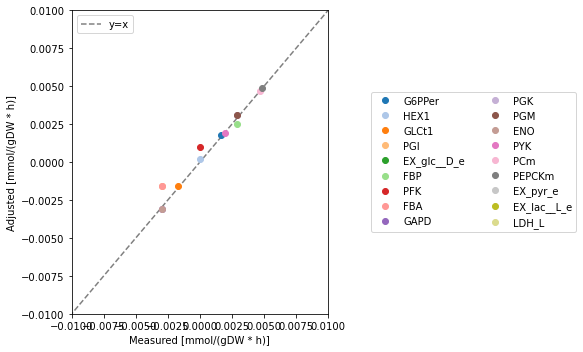

In [20]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.01,0.01), ylim=(-0.01, 0.01),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


# Escher FBA: shows the solutions on the map

In [21]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ), reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(never_ask_before_quit=True, reaction_data={'HEX1': 0.00023284412968333355, 'PGI': -0.00155272088583333…

## Create MASS model

In [22]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x07fb08fe4fcd0
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [23]:
reaction_list=[]
reaction_list = ['HEX1',
                'PGI',
                'FBP',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                'PEPtm',
                 'PEPCKm',
                'PYK',
                'PCm',
                'LDH_L',
                'G6Pter',
                'G6PPer',
                'GLCter',
                'GLCt1',
                'PYRt2m', 
                'H2Oter', 
                'PIter', 
                'H2Ot', 
                'PIt', 
                'Ht', 
                'L_LACt2r', #lactose transport between lactate in cytosol and extracellular 
                 'PYRt2']
    
    
  

In [24]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = trial.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

### View model to be created

In [25]:
escher_builder = escher.Builder(
    model=glycogenolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder

Builder(highlight_missing=True, never_ask_before_quit=True)

##  Set Fluxes

In [26]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0002977156684337587
v_PGI: -0.001985316688230929
v_FBP: 0.003231663479709332
v_PFK: 0.0012463467914784034
v_FBA: -0.0019853166882309293
v_TPI: -0.0019853166882309293
v_GAPD: -0.0039706333764618585
v_PGK: 0.0039706333764618585
v_PGM: 0.0039706333764618585
v_ENO: -0.0039706333764618585
v_PEPtm: 0.0064649636590163794
v_PEPCKm: 0.0062358257063863005
v_PYK: 0.00249433028255452
v_PCm: 0.00599032075777909
v_LDH_L: 0.10787846106
v_G6Pter: 0.002283032356664687
v_G6PPer: 0.002283032356664687
v_GLCter: -0.002283032356664687
v_GLCt1: -0.0019853166882309284
v_PYRt2m: 0.12578402070574954
v_H2Oter: 0.002283032356664687
v_PIter: 0.002283032356664687
v_H2Ot: 0.009485329212835876
v_PIt: 0.003020365553819499
v_Ht: -0.10046322957834125
v_L_LACt2r: 0.10787846106
v_PYRt2: 0.015411229363195002


## Set Keqs

In [27]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,28.077000
G6PPer,3.597122
PGI,0.925000
G6Pter,1.000000
GLCter,1.000000
PFK,514.595916
FBP,154.661691
FBA,0.000205


In [28]:
# setting exchange constants as 1
transport= ["Ht", 
            "H2Ot", 
            "H2Oter",
            'PIter',
            'PIt',
            'G6Pter',
            'GLCter',
            'GLCt1',
            'PYRt2m',
            'PEPtm',
            'L_LACt2r', 
            'PYRt2'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.Keq=1



### Setting Equilibrium Constants

In [29]:
Keq_list =[]

for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))

Keq_GLCt1: 1.0
Keq_HEX1: 28.077
Keq_G6PPer: 3.597122302158273
Keq_PGI: 0.925
Keq_G6Pter: 1.0
Keq_GLCter: 1.0
Keq_PFK: 514.5959163
Keq_FBP: 154.6616914
Keq_FBA: 0.0002049897414
Keq_TPI: 8.772406043
Keq_GAPD: 0.6279182855
Keq_PGK: 0.0005001317907
Keq_PGM: 5.726157133
Keq_ENO: 4.364891179
Keq_PEPCKm: 0.005536708019
Keq_PYK: 23920.23878
Keq_PCm: 11.96327186
Keq_LDH_L: 6.404569654e-05


## Obtain Concentrations

In [30]:
compartment_finder_re = re.compile(r"\s*\[([A-Za-z])\]")
rateconst_re = re.compile(r"k_(\S*)_(fwd|rev)\Z")
bound_metabolites_re = re.compile(r"&|@|#")

In [31]:
#Function to add underscore in front of metabolite identifiers which start with a number
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [32]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in glycogenolysis.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
glycogenolysis.repair()

In [33]:
 for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: None
atp_c: None
g6p_c: None
glc__D_c: None
h_c: None
f6p_c: None
h2o_c: None
pi_c: None
fdp_c: None
dhap_c: None
g3p_c: None
_13dpg_c: None
nad_c: None
nadh_c: None
_3pg_c: None
_2pg_c: None
pep_c: None
pep_m: None
pi_m: None
co2_m: None
gdp_m: None
gtp_m: None
oaa_m: None
pyr_c: None
adp_m: None
atp_m: None
hco3_m: None
h_m: None
pyr_m: None
lac__L_c: None
g6p_r: None
glc__D_r: None
h2o_r: None
pi_r: None
glc__D_e: None
h2o_e: None
pi_e: None
h_e: None
lac__L_e: None
pyr_e: None


In [34]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744
glc__D_r,D-Glucose,0.010483
f6p_c,D-Fructose-6-phosphate,0.000127
pi_c,Phosphate,0.006400


In [35]:
# Fix identifiers in the dataframe
conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [36]:
#Set Concentrations

metabolite_list = [
# HEX1    
                    'glc__D_c',
                    'g6p_c',
                    'adp_c',
                    'atp_c',
                    'h_c',
# GLCt1
                    'glc__D_e',

# #G6Pter
                    'g6p_r',

# #G6PPer , #GLCter
                    'h2o_r',
                    'glc__D_r',
                    'pi_r',
#  'PGI',
                    'f6p_c', 
# 'H2Oter',
                    'h2o_c',

# 'PIter',
                    'pi_r',
                    'pi_c',

#'H2Ot',
                    'h2o_e',
#'PIt',
                    'pi_e',

#'Ht'
                    'h_e'  ,
# PFK/ FBP
                    'fdp_c',
# FBA/TPI
                    'dhap_c',
                    'g3p_c',
# GAPD
                    'nad_c',
                    'nadh_c',
                    '_13dpg_c',
#PGK
                    '_3pg_c',
#PGM
                    '_2pg_c',
#ENO
                    'pep_c',
#PYK
                    'pyr_c',
#PYRt2m #what should we do about h_i
                    'h_m',
                    'pyr_m',
#PCm
                    'hco3_m',
                    'pi_m',
                    'atp_m',
                    'adp_m',
                    'oaa_m',
#PEPCKm
                    'gtp_m',
                    'co2_m',
                    'gdp_m',
                    'pep_m',
#PEPtm
                    "lac__L_c",
                    "lac__L_e",
                    "pyr_e",

]

In [37]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: None
f6p_c: 0.00012713765
h2o_c: None
pi_c: 0.0064
fdp_c: 5.1470825e-05
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
_13dpg_c: None
nad_c: 0.00182530972
nadh_c: 4.63542e-06
_3pg_c: 0.000520630485
_2pg_c: 0.000110560855
pep_c: 0.00031
pep_m: 0.0020499999999999997
pi_m: 0.00045
co2_m: None
gdp_m: None
gtp_m: None
oaa_m: 3.119e-05
pyr_c: 0.00047999999999999996
adp_m: 0.008038905800000001
atp_m: 0.00919
hco3_m: None
h_m: None
pyr_m: 0.00134
lac__L_c: 0.00326183772
g6p_r: 0.000386553505
glc__D_r: 0.01048280703
h2o_r: None
pi_r: 0.0097441228
glc__D_e: 0.0
h2o_e: None
pi_e: 0.0064
h_e: None
lac__L_e: 0.014
pyr_e: 0.007


## Set H2O/H Constants

In [38]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",'h_e','h_m',
    'h2o_r','h2o_e',"h2o_c",
    "glc__D_e", "pi_e",'pi_m','pi_c'
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [39]:
for metabolite in [
    #'h_i',
    'h_m',
"h_c", 'h_e',
"h2o_c",'h2o_r','h2o_e' 
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [40]:
for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
h2o_c: 1
pi_c: 0.0064
fdp_c: 5.1470825e-05
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
_13dpg_c: None
nad_c: 0.00182530972
nadh_c: 4.63542e-06
_3pg_c: 0.000520630485
_2pg_c: 0.000110560855
pep_c: 0.00031
pep_m: 0.0020499999999999997
pi_m: 0.00045
co2_m: None
gdp_m: None
gtp_m: None
oaa_m: 3.119e-05
pyr_c: 0.00047999999999999996
adp_m: 0.008038905800000001
atp_m: 0.00919
hco3_m: None
h_m: 1
pyr_m: 0.00134
lac__L_c: 0.00326183772
g6p_r: 0.000386553505
glc__D_r: 0.01048280703
h2o_r: 1
pi_r: 0.0097441228
glc__D_e: 0.0
h2o_e: 1
pi_e: 0.0064
h_e: 1
lac__L_e: 0.014
pyr_e: 0.007


In [41]:
#Formulate QP minimization list for concentrations

conc_solver = ConcSolver(
    glycogenolysis, 
    excluded_metabolites=[
    "h_c",'h_e', 'h_m',
    'h2o_r','h2o_e',"h2o_c",
    "pi_e",
    "glc__D_e", "lac__L_e",
    "pyr_e"
    ], excluded_reactions=["Ht", 
            "H2Ot", 
            "H2Oter",
            'PIter',
            'PIt',
            'G6Pter',
            'GLCter',
            'GLCt1',
            'PYRt2m',
            'PEPtm',
            'L_LACt2r', 
            'PYRt2'
                          ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
adp_c,0.000436,0.0
atp_c,0.021620,0.0
g6p_c,0.000100,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000179,0.0
...,...,...
Keq_PEPCKm,0.005537,0.0
Keq_PYK,23920.238780,0.0
Keq_PCm,11.963272,0.0
Keq_LDH_L,0.000204,0.0


In [42]:
conc_solution.concentrations

adp_c       4.361834e-04
atp_c       2.162033e-02
g6p_c       9.970066e-05
glc__D_c    1.048281e-02
f6p_c       1.785271e-04
pi_c        6.400000e-03
fdp_c       1.698049e-05
dhap_c      4.125041e-05
g3p_c       7.567240e-05
_13dpg_c    3.468307e-05
nad_c       1.274224e-03
nadh_c      6.640181e-06
_3pg_c      8.315167e-04
_2pg_c      1.378416e-04
pep_c       7.120408e-04
pep_m       2.050000e-03
pi_m        4.500000e-04
co2_m       3.098979e-05
gdp_m       1.000000e-10
gtp_m       1.000000e-10
oaa_m       3.119000e-05
pyr_c       1.503380e-04
adp_m       8.038906e-03
atp_m       9.190000e-03
hco3_m      2.081848e-06
pyr_m       1.340000e-03
lac__L_c    1.041442e-02
g6p_r       3.865535e-04
glc__D_r    1.048281e-02
pi_r        9.744123e-03
Name: concentrations, dtype: float64

In [43]:
# for c in conc_solver.constraints:
#     print(c)

mass/visualization/visualization_util.py:1269 UserWarning: Ignoring {'glc__D_e', 'pyr_e', 'lac__L_e', 'pi_e'}, only in one set of given values


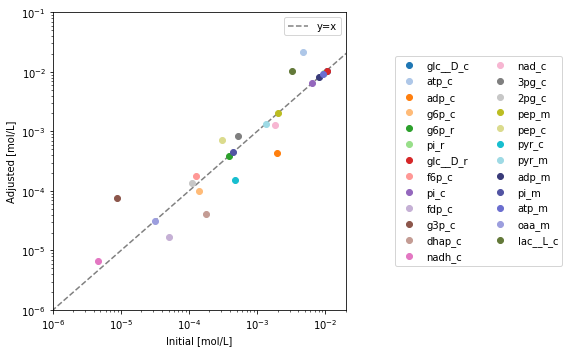

In [51]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [45]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,pi_c,fdp_c,dhap_c,g3p_c,_13dpg_c,...,oaa_m,pyr_c,adp_m,atp_m,hco3_m,pyr_m,lac__L_c,g6p_r,glc__D_r,pi_r
0,0.000449,0.057711,0.000106,0.006229,0.000190,0.000778,0.000059,0.000090,0.000174,0.000118,...,0.000119,0.000866,0.010672,0.002545,0.000008,0.000830,0.008223,0.000203,0.002897,0.007772
1,0.000252,0.037927,0.000015,0.001336,0.000028,0.004450,0.000034,0.000089,0.000170,0.000047,...,0.000268,0.000060,0.016639,0.004236,0.000018,0.001245,0.008292,0.000109,0.001378,0.007780
2,0.000072,0.035964,0.000019,0.005241,0.000035,0.058783,0.000051,0.000112,0.000254,0.000140,...,0.000090,0.000023,0.015844,0.007810,0.000006,0.001822,0.016181,0.000324,0.001816,0.001476


In [46]:
glycogenolysis.boundary_conditions['glc__D_b']=0.010482807 ##  initial condition of the metabolite in the model


In [47]:
# glycogenolysis.steady_state_fluxes.values
glycogenolysis.update_S(array_type="DataFrame")

,HEX1,PGI,FBP,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,...,GLCter,GLCt1,PYRt2m,H2Oter,PIter,H2Ot,PIt,Ht,L_LACt2r,PYRt2
adp_c,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
atp_c,-1,0,0,-1,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
glc__D_c,-1,0,0,0,0,0,0,0,0,0,...,-1,1,0,0,0,0,0,0,0,0
h_c,1,0,0,1,0,0,1,0,0,0,...,0,0,-1,0,0,0,0,1,1,1
f6p_c,0,1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
h2o_c,0,0,-1,0,0,0,0,0,0,1,...,0,0,0,-1,0,1,0,0,0,0
pi_c,0,0,1,0,0,0,-1,0,0,0,...,0,0,0,0,1,0,-1,0,0,0
fdp_c,0,0,-1,1,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dhap_c,0,0,0,0,1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not r.boundary:
#         print(r,v)
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not (r.boundary or r== glycogenolysis.reactions.GLCter or r==glycogenolysis.reactions.PIter):
#             print(r,v)

### Setting rate constants for transport reactions as default value

In [49]:
transport= [
             "Ht", 
            "H2Ot", 
            "H2Oter",
            'PIter',
            'PIt',
            'G6Pter',
            'GLCter',
            'GLCt1',
            'PYRt2m',
            'PEPtm',
            'L_LACt2r', 
            'PYRt2',
        "EX_glc__D_e"
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.kf=1e6

KeyError: 'EX_glc__D_e'

## Set concentrations and balance models with pseudoreactions

In [ ]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
   
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0 or new_model.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items() 
                    if not (r.boundary or r== new_model.reactions.GLCter or r== new_model.reactions.PIter 
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt or 
                            r== new_model.reactions.PYRt2m or 
                            r== new_model.reactions.L_LACt2r or 
                            r== new_model.reactions.PYRt2 or 
                            r== new_model.reactions.PEPtm or r== new_model.reactions.GLCt1 or 
                            r== new_model.reactions.Ht)},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            percs = new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not (r.boundary  or r== new_model.reactions.GLCter or r== new_model.reactions.PIter
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt or 
                            r== new_model.reactions.PYRt2m or 
                            r== new_model.reactions.L_LACt2r or 
                            r== new_model.reactions.PYRt2 or 
                            r== new_model.reactions.PEPtm or r== new_model.reactions.GLCt1 or 
                            r== new_model.reactions.Ht)},
                update_reactions=False)
            print(percs)
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(len(models_for_ensemble)))
# print(models_for_ensemble)

In [ ]:
len(models_for_ensemble)

In [ ]:
for x in list(trial.reactions):
    a= [x.id]
for y in list(glycogenolysis.reactions):
    b=[y.id]

c=[]
for x in b:
    if x not in a:
        c.append(x)
# for x in a:
#      if x not in b:
#         c.append(x)
c        


In [ ]:
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    print(mid, imbalance)

#### Ensure model is in steady state and export

In [ ]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites (sinks)
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0 or glycogenolysis.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance


In [ ]:
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites (exchanges)
for mid, imbalance in imbalanced_metabolites.iteritems():
    if glycogenolysis.metabolites.get_by_id(mid).compartment== "e": 
    # Get metabolite object
        met_ex = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
        boundary_type_ex = "exchange"    
    # Add boundary reaction with imbalance as flux value
        boundary_reaction_ex = glycogenolysis.add_boundary(
            mid, boundary_type_ex, boundary_condition=met_ex.ic)

        boundary_reaction_ex.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance
        if met_ex.ic != 0:
            boundary_reaction_ex.kf = imbalance / met_ex.ic
        
        boundary_reaction_ex.steady_state_flux = imbalance
    
        try:
        # Update PERCs
                percs= glycogenolysis.calculate_PERCs(
                fluxes={
                    r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                    if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                               or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
                                r== new_model.reactions.PYRt2m or 
                                r== new_model.reactions.L_LACt2r or 
                                r== new_model.reactions.PYRt2 or 
                                r== new_model.reactions.PEPtm or r== new_model.reactions.GLCt1 or 
                                r== new_model.reactions.Ht)},
                update_reactions=True)
                print(percs)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue

In [ ]:
escher_builder = escher.Builder(
    model=glycogenolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder

In [ ]:
glycogenolysis.calculate_PERCs(fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
                            r== new_model.reactions.PYRt2m or 
                            r== new_model.reactions.L_LACt2r or 
                            r== new_model.reactions.PYRt2 or 
                            r== new_model.reactions.PEPtm or r== new_model.reactions.GLCt1 or 
                            r== new_model.reactions.Ht)}, update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycogenolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
# glycogenolysis.reactions.EX_glc__D_e.kf= 1000
for reaction in glycogenolysis.reactions:
    print(reaction.id, reaction.kf)

## Balancing charges on reactions manually


In [ ]:
glycogenolysis.metabolites.h_c.charge= 1
glycogenolysis.metabolites.h_e.charge= 1
# glycolysis.metabolites.h_i.charge=1
glycogenolysis.metabolites.pi_c.charge= -2
glycogenolysis.metabolites.pi_e.charge= -2
glycogenolysis.metabolites.pi_m.charge= -2
glycogenolysis.metabolites.h_m.charge= 1
glycogenolysis.metabolites.pi_r.charge= -2

In [ ]:
glycogenolysis.steady_state_fluxes

In [ ]:
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)

In [ ]:
len(glycogenolysis.reactions)

In [ ]:
for x in list(glycogenolysis.genes):
    glycogenolysis.genes.remove(x)

In [ ]:
## Check if this loop is working? (after "Must be a non-negative number" solved)

# while len(list(model.genes)) > 0:
#     for x in list(range(len(list(model.genes)))):
#         #print(a)
#         #a= model.genes[x]
#         model.genes.remove(a)
    
# print(list(model.genes))

In [ ]:
models_for_ensemble

In [ ]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        for x in list(model.genes):
            model.genes.remove(x)
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

In [ ]:
models_for_ensemble = []
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


In [ ]:
# range(len(glycogenolysis.genes)) (rerun until get in empty list)
for x in list(glycogenolysis.genes):
    glycogenolysis.genes.remove(x)
print(list(glycogenolysis.genes))



In [ ]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [M]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
fig_1



In [ ]:
fig_2, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}

plot_time_profile(
    flux_sol, observable="SK_f6p_c", ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
plot_time_profile(
    flux_sol, observable="PGI", ax=ax1, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));


In [ ]:
fig_2, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}

plot_time_profile(
    flux_sol, observable=['HEX1',
                'PGI',
                'FBP',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                'PEPtm',
                 'PEPCKm',
                'PYK',
                'PCm',
                'LDH_L',
                'G6Pter',
                'G6PPer',
                'GLCter',
                'GLCt1',
                'PYRt2m', 
                'H2Oter', 
                'PIter', 
                'H2Ot', 
                'PIt', 
                'Ht', 
                'L_LACt2r', #lactose transport between lactate in cytosol and extracellular 
                 'PYRt2'], ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
plot_time_profile(
    flux_sol, observable="G6Pter", ax=ax1, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));

In [ ]:
#Analysis
fig_2, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}

plot_time_profile(
    flux_sol, observable="HEX1", ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
plot_time_profile(
    flux_sol, observable="G6Pter", ax=ax1, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));

In [ ]:
len(trial.reactions)

In [ ]:
len(glycogenolysis.reactions)